<a href="https://colab.research.google.com/github/jdtoscano94/Hybrid-RL-GAN-Point_Cloud_Completion/blob/main/5_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Install

In [ ]:
cd /content/gdrive/MyDrive/JMSE2022/MoldScan

/content/gdrive/MyDrive/JMSE2022/MoldScan


In [ ]:
!pip install pyntcloud
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
!curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
!tar xzf 1.10.0.tar.gz
os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k  100  404k    0     0   267k      0  0:00:01  0:00:01 --:--:--  627k
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-mihc680f
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-mihc680f


In [ ]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
import tqdm
#%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['savefig.dpi'] = 80
#mpl.rcParams['figure.dpi'] = 80

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
import pandas as pd
import datetime


from pytorch3d import structures
from pyntcloud import PyntCloud
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torch import autograd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# Tunning Parameters

In [ ]:
#Arquitecture
num_points=2048
lay=np.array([[128,128,256,128]])
layD=np.array([[128,128,128,256,num_points*3]])
batch_size=1
batch_size2=10
batch_size_actor = 100
momentum = 0.8
n_epochs=10000
#Learning rate decay
lim=50
lr=5.0e-4
g_lr = 5.0e-4
d_lr = 5.0e-4
decay=0.00 
im_size=32
sag1=64
sag2=64
sad1=256
sad2=256
lrates=np.array([[lr,g_lr,d_lr,decay]])
# Seed Dimension
z_dim = 32
Lambda=10
# RL Agent
max_action = 10
max_steps = 2e4
#Shrink Amount
shrink=15
#Plot
mark=1



In [ ]:
newdim=math.ceil(num_points*((100-shrink)/100))
print(newdim)


1741


# Other Functions

In [ ]:
def Filter1(PCs,size_text):
  pointsAE = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)
  pointsAE= (pointsAE - (-0.5)) / (0.5 - (-0.5))
  aligned_Tensor = PointcloudDatasetNoisy('', pointsAE)
  aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)
  aligned_Tensor2 = PointcloudDatasetNoisy('', PCs)
  aligned_dataloader2 = DataLoader(aligned_Tensor2, num_workers=0, shuffle=True, batch_size=1)
  min= 5.1408e-05
  max=0.0005065033
  x=aligned_dataloader.dataset[0].float().to(device)
  x= x.unsqueeze(0)
  final_points=PCs
  chamf_list_Org=[]
  size=len(PCs)
  remove=[]
  start=0
  for i in range(1):
    for j in tqdm(range(0,size)):
        if not j in remove:
          y=aligned_dataloader2.dataset[j].float().to(device)
          y= y.unsqueeze(0)
          loss_chamf,_=chamfer_distance(x,y)
          chamf_list_Org.append(loss_chamf.detach().cpu().numpy())
          if loss_chamf<min:
            remove.append(j)
          if loss_chamf>max:
            remove.append(j)
        
  #Sturge’s Rule
  fig, ax1 = plt.subplots(figsize=(7, 6))
  plt.rcParams['font.size'] = str(size_text)
  print("Removed Points:",len(remove),".Remaining Points:",size-len(remove))
  bn=int(np.round(1+3.322*np.log10(30)))
#_ = plt.hist(chamf_list, bins=np.array(8))

  _ = plt.hist(chamf_list_Org, bins=bn)
  plt.ticklabel_format(useOffset=True, style='sci')
  #plt.title("Remaining PCs")
  print("Average:",np.mean(chamf_list_Org),"Std",np.std(chamf_list_Org))
  return remove,chamf_list_Org

def Filter2(chamf_list,desc=False):
  min= 5.1408e-05
  max=0.0009
  avg=(min+max)/2
  chamf_list=np.where(chamf_list==0,avg,chamf_list)
  ct_idx=np.zeros(len(chamf_list))
  remove=[]
  control=2
  while control>0:
  #print(chamf_list)
    for i in range(len(chamf_list)):
      a=chamf_list[:,i]
      ct_idx[i]=np.count_nonzero(a < min)
    id=np.argmax(ct_idx)
    if ct_idx[id]>0:
      remove.append(id)
      chamf_list[id,:]=avg
      chamf_list[:,id]=avg
    control=np.average(ct_idx)
  if desc==True:
    print(remove)
    print(np.average(ct_idx))
    print(ct_idx)
  return remove

def genPCs(generator, autoencoder,number_PCs=10000,z_dim=z_dim,it=0,zf=0):
  if it==0:
    zf = torch.randn(number_PCs, z_dim).to(device)
  else:
    cov=np.cov(np.transpose(zf))
    mu=np.mean(zf)
    mean=mu*np.ones(32)
    print(mu)
    z_controlled= np.random.multivariate_normal(mean, cov,number_PCs)
    z_controlled.shape
    zf=torch.from_numpy(z_controlled).to(device)
    zf=zf.type(torch.cuda.FloatTensor)
  with torch.no_grad():
    gen_out, _ = generator(zf)
    out_data = autoencoder.decode(gen_out)
    out_data = out_data.detach().cpu().numpy()
  #np.save('PC_Arrays/It-'+str(it)+'-PCs-'+str(out_data.shape[0])+'.npy', out_data)
  #np.save('PC_Arrays/It-'+str(it)+'-Zs-'+str(out_data.shape[0])+'.npy', zf.detach().cpu().numpy())
  return out_data,zf.detach().cpu().numpy()

def RemovePCs(remove=[],PCs=[],z=[]):
  pointsAE2=[]
  zf=[]
  for i in range(len(PCs)):
    if  not i in remove:
      pointsAE2.append(PCs[i])
      zf.append(z[i])
  return pointsAE2,zf

def chamf_Mat(it=0,PCs=[]):
  aligned_Tensor2 = PointcloudDatasetNoisy('DATA_DIR', PCs)
  aligned_dataloader2 = DataLoader(aligned_Tensor2, num_workers=0, shuffle=True, batch_size=1)
  chamf_list=np.zeros((len(PCs),len(PCs)))
  for i in tqdm(range(len(PCs))):
    x=aligned_dataloader2.dataset[i].float().to(device)
    x= x.unsqueeze(0)
    for j in range(len(PCs)):
        y=aligned_dataloader2.dataset[j].float().to(device)
        y= y.unsqueeze(0)
        loss_chamf,_=chamfer_distance(x,y)
        chamf_list[i][j]=loss_chamf.detach().cpu().numpy()
  #np.save('PC_Arrays/Pairs-it-'+str(it)+'.npy', chamf_list)
  return chamf_list

def Filter22(chamf_list2=[],desc=False):
  min= 5.1408e-05
  max=0.0004
  avg=(min+max)/2
  #chamf_list=np.where(chamf_list==0,avg,chamf_list)
  for i in range(len(chamf_list2)):
    chamf_list2[i][i]=avg
  ct_idx=np.zeros(len(chamf_list2))
  remove=[]
  control=2
  chamf_list=chamf_list2
  while control>0:
  #print(chamf_list)
    for i in range(len(chamf_list2)):
      a=chamf_list[:,i]
      ct_idx[i]=np.count_nonzero(a < min)
      #print(ct_idx[i])
    id=np.argmax(ct_idx)
    if ct_idx[id]>0:
      remove.append(id)
      chamf_list[id,:]=avg
      chamf_list[:,id]=avg
    control=np.average(ct_idx)
  if desc==True:
    print(remove)
    print(np.average(ct_idx))
    print(ct_idx)
  return remove

In [ ]:
def Mirror(X):
  mirror=np.eye(3)
  mirror[0][0]=-1
  X=X@mirror
  return X

def normalize(x,mu,std):
  x=1+(x-mu)/std
  return x

def test_model2(generator, autoencoder,epoch,n=2,plotmod=True,PCs=[]):
      chamf_list2=[]
      compare=aligned_dataloader.dataset[10].float().to(device)
      compare= compare.unsqueeze(0)
      for i in tqdm.trange(n):
        # points = PyntCloud.from_file(X_test[i])
        # points = np.array(points.points)
        # points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        # points = points_normalized.astype(np.float)
        # points = torch.from_numpy(points).unsqueeze(0)
        # points = points.permute([0,2,1]).float().to(device)
        # print(points.shape)

        autoencoder.eval()
        generator.eval()
        z = torch.randn(1, z_dim).to(device)
        with torch.no_grad():
                gen_out, _ = generator(z)
                out_data = autoencoder.decode(gen_out)
                # loss = chamfer_loss(out_data, points)
        # print(loss.item())
        loss_chamf,_=chamfer_distance(compare,out_data)
        out_data=out_data.permute([0,2,1])
        chamf_list2.append(loss_chamf.detach().cpu().numpy())
        #PCs.append(out_data.detach().cpu().numpy())
        output = out_data[0,:,:]
        output = output.permute([1,0]).detach().cpu().numpy()
        # inputt = points[0,:,:]
        # inputt = inputt.permute([1,0]).detach().cpu().numpy()
        if plotmod==True:
          fig = plt.figure()
          ax_x = fig.add_subplot(111, projection='3d')
          ax_x.text2D(0.05, 0.95, str(i), transform=ax_x.transAxes)
          x_ = output
          ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
          ax_x.set_xlim([0,1])
          ax_x.set_ylim([0,1])
          ax_x.set_zlim([0,1])
          print(out_data.shape)   
          fig.savefig(OUTPUTS_DIR+'Fake-'+'{}_{}.png'.format(i, 'out'))
        out_data=out_data.permute([0,2,1]) 
        PCs.append(out_data[0].detach().cpu().numpy())
        #np.save('PC_Arrays/PCs(RL-GAN)-Final.npy', PCs)
      return np.array(chamf_list2)


def normalize(x,mu,std):
  x=1+(x-mu)/std
  return x

def plot(points):
  inputt = points[0,:,:]
  inputt = inputt.permute([1,0]).detach().cpu().numpy()

  fig = plt.figure()
  ax_x = fig.add_subplot(111, projection='3d')
  x_ = inputt
  ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
  ax_x.set_xlim([0,1])
  ax_x.set_ylim([0,1])
  ax_x.set_zlim([0,1])

def MoveScale3D(a,dx,dy,dz,s):
  T=np.array([[s,0,0,0],[0,s,0,0],[0,0,s,0],[dx,dy,dz,1]])
  aux=np.ones((a.shape[0],a.shape[1]+1))
  aux[:,:-1] = a
  a=aux@T
  a=a[:,[0,1,2]]
  return a

def centroid(arrdwn):
  cx=0
  cy=0
  cz=0
  for i in range(len(arrdwn)):
    cx=cx+arrdwn[i][0]
    cy=cy+arrdwn[i][1]
    cz=cz+arrdwn[i][2]
  cx=cx/len(arrdwn)
  cy=cy/len(arrdwn)
  cz=cz/len(arrdwn)
  print("the centroid is at:",cx,cy,cz)
  return cx,cy,cz

In [ ]:
def RemovePoints(ext,shrink):
  DATA_DIR = './2048Samples/'+ext
  directory =DATA_DIR 
  list_point_clouds=[None]*120
  i=0
  for filename in os.listdir(directory):
    list_point_clouds[i]=str(os.path.join(directory, filename))
    i=i+1
  list_new_data = []
  for i in tqdm.trange(len(list_point_clouds)):
    points = PyntCloud.from_file(list_point_clouds[i])
    points = np.array(points.points[0:2048])
    points=points[:,[0,1,2]]
    points = points.astype(np.float)
    seed_idx = int(np.random.rand() * 2048 * shrink/100)
    points_removed = np.concatenate((points[:seed_idx, :], points[seed_idx + int(((100-shrink)/100)*2048):, :]), axis=0)
    list_new_data.append(points_removed)
  np.save('list_point_noisy.npy', list_new_data)
  return list_new_data

In [ ]:
def listDir(directory):
  directory=directory
  list_point_clouds=[]
  for filename in os.listdir(directory):
    list_point_clouds.append(str(os.path.join(directory, filename)))
  return list_point_clouds

In [ ]:
def PlotOr(ext,num):
  DATA_DIR = './2048Samples/'+ext
  directory =DATA_DIR 
  names2=[None]*120
  i=0
  for filename in os.listdir(directory):
    names2[i]=str(os.path.join(directory, filename))
    i=i+1
  for i in range(num):
    points = PyntCloud.from_file(names2[i])
    points = np.array(points.points[0:2048])
    points=points[:,[0,1,2]]
    points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
    points = points_normalized.astype(np.float)
    inputt = points[:,:]
    fig = plt.figure()
    ax_x = fig.add_subplot(111, projection='3d')
    x_ = inputt
    ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
    ax_x.set_xlim([0,1])
    ax_x.set_ylim([0,1])
    ax_x.set_zlim([0,1])

In [ ]:
def plotList(num,list_point_clouds):
  for i in range(num):
    points = list_point_clouds[i]
    points = np.array(points)
    points=points[:,[0,1,2]]
    points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
    points = points_normalized.astype(np.float)
    inputt = points[:,:]
    fig = plt.figure()
    ax_x = fig.add_subplot(111, projection='3d')
    x_ = inputt
    ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
    ax_x.set_xlim([0,1])
    ax_x.set_ylim([0,1])
    ax_x.set_zlim([0,1])

In [ ]:
def normalize(x,mu,std):
  x=1+(x-mu)/std
  return x

def plot(points,show=False):
  input=points
  #inputt = points[0,:,:]
  #inputt = inputt.permute([1,0]).detach().cpu().numpy()
  size=np.max(points)
  fig = plt.figure()
  ax_x = fig.add_subplot(111, projection='3d')
  x_ = input
  ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
  ax_x.set_xlim([-size,size])
  ax_x.set_ylim([-size,size])
  ax_x.set_zlim([-size,size])
  if show==True:
    ax_x.view_init(azim=1, elev=90)


def MoveScale3D(a,dx,dy,dz,s):
  T=np.array([[s,0,0,0],[0,s,0,0],[0,0,s,0],[dx,dy,dz,1]])
  aux=np.ones((a.shape[0],a.shape[1]+1))
  aux[:,:-1] = a
  a=aux@T
  a=a[:,[0,1,2]]
  return a


def centroid(arrdwn):
  cx=0
  cy=0
  cz=0
  for i in range(len(arrdwn)):
    cx=cx+arrdwn[i][0]
    cy=cy+arrdwn[i][1]
    cz=cz+arrdwn[i][2]
  cx=cx/len(arrdwn)
  cy=cy/len(arrdwn)
  cz=cz/len(arrdwn)
  print("the centroid is at:",cx,cy,cz)
  return cx,cy,cz

  

In [ ]:
def plotList(num,list_point_clouds,show=False):
  for i in range(num):
    points = list_point_clouds[i]
    points = np.array(points)
    points=points[:,[0,1,2]]
    points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
    points = points_normalized.astype(np.float)
    inputt = points[:,:]
    fig = plt.figure()
    ax_x = fig.add_subplot(111, projection='3d')
    x_ = inputt
    ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
    ax_x.set_xlim([0,1])
    ax_x.set_ylim([0,1])
    ax_x.set_zlim([0,1])
    if show==True:
      ax_x.view_init(azim=1, elev=90)

class PointcloudDatasetNoisy(Dataset):
    def __init__(self,root,list_point_clouds):
        self.root = root
        self.list_files = list_point_clouds
        
    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        points = self.list_files[index]
        points=points[:,[0,1,2]]
        points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        points = points_normalized.astype(np.float)
        points = torch.from_numpy(points)
        
        return points

def load_checkpoint(model,filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        #start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        #optimizer.load_state_dict(checkpoint['optimizer'])
        #cost_list=checkpoint['Training_Loss']
        #cost_val_list=checkpoint['Validation_Loss']
        #gfv_list=checkpoint['GFV']
        #chamf_list=checkpoint['Chamfer_Loss']
        #OUTPUTS_DIR=checkpoint['Out_dir']
        #losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model

import math as m
def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
  
def Ry(theta):
  return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
  
def Rz(theta):
  return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])
fac=180/np.pi

In [ ]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

# Al Models



### Replay Buffer

In [ ]:
class ReplayBuffer():
    def __init__(self, size):
        self.episodes = []
        self.buffer_size = size

    def add_to_buffer(self, state, action, reward, next_state):
        if len(self.episodes) == self.buffer_size:
            self.episodes = self.episodes[1:]
        self.episodes.append((state.detach().cpu().numpy(), action.detach().cpu().numpy(), reward.detach().cpu().numpy(), next_state.detach().cpu().numpy()))

    def get_batch(self, batch_size=batch_size2):
        states = []
        actions = []
        rewards = []
        next_state = []
        done = []

        for i in range(batch_size):
            epi = random.choice(self.episodes)
            states.append(epi[0])
            actions.append(epi[1])
            rewards.append(epi[2])
            next_state.append(epi[3])
        
        rewards = np.array(rewards)
        rewards = rewards.reshape((rewards.shape[0],1))
        return torch.Tensor(states), torch.Tensor(actions), torch.Tensor(rewards), torch.Tensor(next_state)

### Critic Network

In [ ]:
class CriticNet(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(CriticNet, self).__init__()

		self.l1 = nn.Linear(state_dim + action_dim, 400)
		self.l2 = nn.Linear(400, 300)
		self.l3 = nn.Linear(300, 1)


	def forward(self, x, u):
		x = F.relu(self.l1(torch.cat([x, u], 1)))
		x = F.relu(self.l2(x))
		x = self.l3(x)
		return x 

## Actor Network

In [ ]:
class ActorNet(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(ActorNet, self).__init__()

		self.l1 = nn.Linear(state_dim, 400)
		self.l2 = nn.Linear(400, 300)
		self.l3 = nn.Linear(300, action_dim)
		
		self.max_action = max_action

	
	def forward(self, x):
		x = F.relu(self.l1(x))
		x = F.relu(self.l2(x))
		x = self.max_action * torch.tanh(self.l3(x)) 
		return x 


## Autoencoder

In [ ]:
class Encoder(nn.Module):

    def __init__(self,p=0):
        super(Encoder, self).__init__()
        conv1 = [nn.Conv1d(3, lay[0][0], kernel_size=1), 
                nn.BatchNorm1d(lay[0][0]),
                nn.Dropout(p=p),
                nn.ReLU()]
        conv2 = [nn.Conv1d(lay[0][0], lay[0][1], kernel_size=1), 
                nn.BatchNorm1d(lay[0][1]),
                nn.Dropout(p=p),
                nn.ReLU()]
        conv3 = [nn.Conv1d(lay[0][1], lay[0][2], kernel_size=1), 
                nn.BatchNorm1d(lay[0][2]),
                nn.Dropout(p=p),
                nn.ReLU()]
        conv4 = [nn.Conv1d(lay[0][2], lay[0][3], kernel_size=1), 
                nn.BatchNorm1d(lay[0][3]),
                nn.AdaptiveMaxPool1d(1)]
        self.conv1 = nn.Sequential(*conv1)
        self.conv2 = nn.Sequential(*conv2)        
        self.conv3 = nn.Sequential(*conv3)
        self.conv4 = nn.Sequential(*conv4)
        
    def forward(self, x):
        x=x.permute([0,2,1])
        out_1 = self.conv1(x)
        out_2 = self.conv2(out_1)
        out_3 = self.conv3(out_2)
        out_4 = self.conv4(out_3)
        out_4 = out_4.view(-1, out_4.shape[1])
        return out_4


class Decoder(nn.Module):
    def __init__(self, num_points,p=0):
        super(Decoder, self).__init__()
        linear1 = [nn.Linear(layD[0][0], layD[0][1]), 
                nn.BatchNorm1d(layD[0][1]),
                nn.ReLU(),
                nn.Dropout(p=p)]
        linear2 = [nn.Linear(layD[0][1], layD[0][2]), 
                nn.BatchNorm1d(layD[0][2]),
                nn.ReLU(),
                nn.Dropout(p=p)]
        linear25 = [nn.Linear(layD[0][2], layD[0][3]), 
                nn.BatchNorm1d(layD[0][3]),
                nn.ReLU(),
                nn.Dropout(p=p)]
        linear3 = [nn.Linear(layD[0][3], layD[0][4]), 
                nn.ReLU(),
                nn.Dropout(p=p)]
        self.linear1 = nn.Sequential(*linear1)
        self.linear2 = nn.Sequential(*linear2)
        self.linear25 = nn.Sequential(*linear25)
        self.linear3 = nn.Sequential(*linear3)
        self.num_points = num_points
        
    def forward(self, x):
        out_1 = self.linear1(x)
        out_2 = self.linear2(out_1)
        out_25 = self.linear25(out_2)
        out_3 = self.linear3(out_25)
        out_3= out_3.view(-1, 3, self.num_points)
        out_3=out_3.permute([0,2,1])
        return out_3


class AutoEncoder(nn.Module):
    def __init__(self, num_points):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(num_points)
        
    def encode(self, x):
        gfv = self.encoder(x)
        # out = self.decoder(gfv)
        return gfv

    def decode(self, x):
        return self.decoder(x)


## Autoencoder-Hybrid

In [ ]:
class Encoder2(nn.Module):

    def __init__(self,p=0):
        super(Encoder2, self).__init__()
        conv1 = [nn.Conv1d(3, lay[0][0], kernel_size=1), 
                nn.BatchNorm1d(lay[0][0]),
                nn.Dropout(p=p),
                nn.ReLU()]
        conv2 = [nn.Conv1d(lay[0][0], lay[0][1], kernel_size=1), 
                nn.BatchNorm1d(lay[0][1]),
                nn.Dropout(p=p),
                nn.ReLU()]
        conv3 = [nn.Conv1d(lay[0][1], lay[0][2], kernel_size=1), 
                nn.BatchNorm1d(lay[0][2]),
                nn.Dropout(p=p),
                nn.ReLU()]
        conv4 = [nn.Conv1d(lay[0][2], lay[0][3], kernel_size=1), 
                nn.BatchNorm1d(lay[0][3]),
                nn.MaxPool1d(2048)]
        self.conv1 = nn.Sequential(*conv1)
        self.conv2 = nn.Sequential(*conv2)        
        self.conv3 = nn.Sequential(*conv3)
        self.conv4 = nn.Sequential(*conv4)
        
    def forward(self, x):
        x=x.permute([0,2,1])
        out_1 = self.conv1(x)
        out_2 = self.conv2(out_1)
        out_3 = self.conv3(out_2)
        out_4 = self.conv4(out_3)
        out_4 = out_4.view(-1, out_4.shape[1])
        return out_4


class Decoder2(nn.Module):
    def __init__(self, num_points,p=0):
        super(Decoder2, self).__init__()
        linear1 = [nn.Linear(layD[0][0], layD[0][1]), 
                nn.BatchNorm1d(layD[0][1]),
                nn.ReLU(),
                nn.Dropout(p=p)]
        linear2 = [nn.Linear(layD[0][1], layD[0][2]), 
                nn.BatchNorm1d(layD[0][2]),
                nn.ReLU(),
                nn.Dropout(p=p)]
        linear25 = [nn.Linear(layD[0][2], layD[0][3]), 
                nn.BatchNorm1d(layD[0][3]),
                nn.ReLU(),
                nn.Dropout(p=p)]
        linear3 = [nn.Linear(layD[0][3], layD[0][4]), 
                nn.ReLU(),
                nn.Dropout(p=p)]
        self.linear1 = nn.Sequential(*linear1)
        self.linear2 = nn.Sequential(*linear2)
        self.linear25 = nn.Sequential(*linear25)
        self.linear3 = nn.Sequential(*linear3)
        self.num_points = num_points
        
    def forward(self, x):
        out_1 = self.linear1(x)
        out_2 = self.linear2(out_1)
        out_25 = self.linear25(out_2)
        out_3 = self.linear3(out_25)
        out_3= out_3.view(-1, 3, self.num_points)
        out_3=out_3.permute([0,2,1])
        return out_3


class AutoEncoder2(nn.Module):
    def __init__(self, num_points):
        super(AutoEncoder2, self).__init__()
        self.encoder = Encoder2()
        self.decoder = Decoder2(num_points)
        
    def encode(self, x):
        gfv = self.encoder(x)
        # out = self.decoder(gfv)
        return gfv

    def decode(self, x):
        return self.decoder(x)


## Generator

In [ ]:
class GenSAGAN(nn.Module):
    def __init__(self, image_size=im_size, z_dim=32, conv_dim=64):
        super(GenSAGAN, self).__init__()
        repeat_num = int(np.log2(image_size)) - 3
        mult = 2 ** repeat_num

        self.layer1 = SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim*mult, 4))
        self.bn1 = nn.BatchNorm2d(conv_dim*mult)

        self.layer2 = SpectralNorm(nn.ConvTranspose2d(conv_dim*mult, (conv_dim*mult)//2, 3, 2, 2))
        self.bn2 = nn.BatchNorm2d((conv_dim*mult)//2)

        self.layer3 = SpectralNorm(nn.ConvTranspose2d((conv_dim*mult)//2, (conv_dim*mult)//4, 3, 2, 2))
        self.bn3 = nn.BatchNorm2d((conv_dim*mult)//4)


        self.layer4 = SpectralNorm(nn.ConvTranspose2d(64, 1, 2, 2, 1))
        self.a4 = nn.Tanh()

        self.attn1 = SAttn(sag1)
        #self.attn2 = SAttn(sag2)

        self.conv1d = nn.ConvTranspose1d(144, 128, 1)


    def forward(self, x):
        x = x.view(x.shape[0], x.shape[1], 1, 1)
        out = F.relu(self.layer1(x))
        out = self.bn1(out)

        out = F.relu(self.layer2(out))
        out = self.bn2(out)

        out = F.relu(self.layer3(out))
        out = self.bn3(out)

        
        out ,  p1 = self.attn1(out)

        out = self.layer4(out)

        out= self.a4(out)

        out = out.view(-1, 1, 144)
        out = out.transpose(1, 2)

        out = self.conv1d(out)
        out = out.transpose(2, 1)

        out = out.view(-1, 128)

        return out , p1


class DiscSAGAN(nn.Module):

    def __init__(self, image_size=im_size, conv_dim=64):
        super(DiscSAGAN, self).__init__()
        self.layer1 = SpectralNorm(nn.Conv2d(1, conv_dim, 3, 2, 2))
        self.layer2 = SpectralNorm(nn.Conv2d(conv_dim, conv_dim*2, 3, 2, 2))
        self.layer3 = SpectralNorm(nn.Conv2d(conv_dim*2, conv_dim*4, 3 ,2, 2))

        self.layer4 = SpectralNorm(nn.Conv2d(conv_dim*4, 1, 4))

        self.attn1 = SAttn(sad1)
        #self.attn2 = SAttn(sad2)

        self.conv1d = nn.ConvTranspose1d(128, 144, 1)



    def forward(self, x):
        # x = x.squeeze(1)
        x = x.unsqueeze(-1)
        x = self.conv1d(x)
        x = x.transpose(2, 1)
        x = x.view(-1, 1, 12, 12)

        out = F.leaky_relu(self.layer1(x))
        out = F.leaky_relu(self.layer2(out))
        out = F.leaky_relu(self.layer3(out))

        out, p1 = self.attn1(out)

        out = self.layer4(out)
        out = out.reshape(x.shape[0], -1)
        return out, p1


class SAttn(nn.Module):
    def __init__(self, dim):
        super(SAttn, self).__init__()

        self.query = nn.Conv2d(dim, dim // 8, 1)
        self.key = nn.Conv2d(dim, dim//8, 1)
        self.value = nn.Conv2d(dim, dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, c, w, h = x.size()
        query = self.query(x)
        query = query.view(batch_size, -1, w*h).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, w*h)
        
        matmul = torch.bmm(query, key)
        attn = self.softmax(matmul)

        value = self.value(x).view(batch_size, -1, w*h)

        out = torch.bmm(value, attn.permute(0,2,1))
        out = out.view(batch_size, c, w, h)
        out = self.gamma*out + x

        return out, attn
class DDPG(nn.Module):
    def __init__(self, max_action):
        super(DDPG, self).__init__()
        self.actor = ActorNet(128, z_dim, max_action)
        self.critic = CriticNet(128, z_dim)
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())

        self.replay_buffer = ReplayBuffer(int(max_steps))

    def get_optimal_action(self, state):
        return self.actor(state)

    def forward(self):
        state, action, reward, next_state = self.replay_buffer.get_batch(batch_size_actor)
        
        state = state[:,0,:].float()
        next_state = next_state[:,0,:].float()
        action = action[:,0,:].float()
        state = state.to(device)
        action = action.to(device)
        reward = reward.to(device)
        next_state = next_state.to(device)
        
        target_q = reward

        q_batch = self.critic(state, action)

        self.critic_optimizer.zero_grad()

        value_loss = F.mse_loss(q_batch, target_q)
        value_loss.backward()
        
        self.critic_optimizer.step() 

        self.actor_optimizer.zero_grad()

        policy_loss = - self.critic(state, self.actor(state)).mean()
        policy_loss.backward()
        
        self.actor_optimizer.step()

        return value_loss, policy_loss

# Training

In [ ]:
#Generator and Discriminator
num_gen=8880
size_fake=4000
name='New-Z252-0.8z32-42-0.0005-32-[ 64  64 256 256]-2048-10'
weights_gen = '/content/gdrive/MyDrive/MSEC2022/MoldScan/MoldScanGAN/'+name+'/models/'+str(num_gen)+'_gen_.pt'
weight_disc = '/content/gdrive/MyDrive/MSEC2022/MoldScan/MoldScanGAN/'+name+'/models/'+str(num_gen)+'_disc_.pt'

## Load Previous Data

In [ ]:
autoencoder = AutoEncoder(num_points).to(device)
ext='Orginal+Mirrored-254-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-49-0.8-0.0005-2048-30'
typeFile='Best_Val'
filename='/content/gdrive/MyDrive/MSEC2022/MoldScan/MoldScanAE/'+ext+'/models/'+typeFile+'_ae_.pth.tar'
autoencoder= load_checkpoint(autoencoder,filename=filename)

generator = GenSAGAN(z_dim=z_dim).to(device)
generator.load_state_dict(torch.load(weights_gen))

discriminator = DiscSAGAN().to(device)
discriminator.load_state_dict(torch.load(weight_disc))

ddpg = DDPG(max_action).to(device)

In [ ]:
autoencoder.eval()
generator.eval()
discriminator.eval()

## Data Loader

In [ ]:
org_size=2048
ext_dat='2021-08-28 18:49:59.062451'
DATA_DIR = '/content/gdrive/MyDrive/MSEC2022/MoldScan/2048Samples/'+ext_dat+'/'
#ext='2021-08-26 04:07:29.716666/'
#list_point_clouds=RemovePoints(ext_dat,80)
list_point_clouds = np.load('./PC_Arrays/GAN-1-(254, 2048, 3).npy',allow_pickle=True)

In [ ]:
list_point_clouds.shape

In [ ]:
plotList(10,list_point_clouds[0])

In [ ]:
#firstDist= np.load('./FirstDist.npy',allow_pickle=True)
X_test=list_point_clouds[1]
print(len(X_test))
#train_idx=firstDist[0]
#for i in range(120,list_point_clouds.shape[0]):
#  train_idx=np.append(train_idx,i)
#len(train_idx)
X_train=list_point_clouds[0]
print(X_train.shape)

In [ ]:
#X_train, X_test, _, _ = train_test_split(list_point_clouds, list_point_clouds, test_size=0.1, random_state=42)

In [ ]:
class PointcloudDatasetAE(Dataset):
    def __init__(self, root, list_point_clouds):
        self.root = root
        self.list_files = list_point_clouds
        
    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        points = PyntCloud.from_file(self.list_files[index])
        points.points=points.points[0:2048]
        cx=points.centroid[0]
        cy=points.centroid[1]
        cz=points.centroid[2]
        points = np.array(points.points)
        points=points[:,[0,1,2]]
        points=MoveScale3D(points,-cx,-cy,-cz,1)
        points=points/(2*np.max(points))
        points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        points = points_normalized.astype(np.float)
        points = torch.from_numpy(points)
        
        return points

class PointcloudDatasetNoisy(Dataset):
    def __init__(self,root,list_point_clouds):
        self.root = root
        self.list_files = list_point_clouds
        
    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        points = self.list_files[index]
        points=points[:,[0,1,2]]
        points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        points = points_normalized.astype(np.float)
        points = torch.from_numpy(points)
        
        return points

In [ ]:
train_dataset = PointcloudDatasetNoisy(DATA_DIR, X_train)
train_dataloader = DataLoader(train_dataset, num_workers=0, shuffle=True, batch_size=batch_size)
train_loader_iterator = iter(train_dataloader)

test_dataset = PointcloudDatasetNoisy(DATA_DIR, X_test)
test_dataloader = DataLoader(test_dataset, num_workers=0, shuffle=True, batch_size=1)
test_loader_iterator = iter(test_dataloader)

for i,data in enumerate(train_dataloader):
  print(i)
  if i==0:
    x= data.float().to(device)
    print(x.shape)
  if i==1:
    y = data.float().to(device)
    loss_chamf,_=chamfer_distance(x,y)
    print(loss_chamf)
    break

## Dir

In [ ]:
ROOT_DIR = './MoldScanRLAgent/'+'Fake-'+str(shrink)+'-'+str(max_action)+'-'+str(num_points)+'-'+str(Lambda)

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)

if not os.path.exists(ROOT_DIR ):
    os.makedirs(ROOT_DIR)

LOG_DIR = ROOT_DIR + '/logs/'
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

OUTPUTS_DIR = ROOT_DIR   + '/outputs/'
if not os.path.exists(OUTPUTS_DIR):
    os.makedirs(OUTPUTS_DIR)

MODEL_DIR = ROOT_DIR + '/models/'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

summary_writer = SummaryWriter(LOG_DIR)

In [ ]:
start_time = 1e3


In [ ]:
x=torch.tensor([2048])
y=torch.tensor([newdim])
x=x.to(device)
y=y.to(device)

In [ ]:
print(y)

In [ ]:
OUTPUTS_DIR

## Training

In [ ]:
Reward_list=[]
GFV_list=[]
Discr_list=[]
Chanfer_list=[]
tsteps_list=[]
max_reward=-100000000
for tsteps in range(0,int(max_steps)):
    autoencoder.eval()
    generator.eval()
    discriminator.eval()
    try:
        data = next(train_loader_iterator)
    except StopIteration:
        train_loader_iterator = iter(train_dataloader)
        data = next(train_loader_iterator)
    data = data.float().to(device)
            
    #if tsteps != 0:
        #losses = ddpg()
    #autoencoder.eval()
    with torch.no_grad():   
      state_t = autoencoder.encode(data)
    if tsteps < start_time:
        action_t = -2 * max_action * torch.rand(1, z_dim) + max_action
        action_t = action_t.to(device)
    else:
        action_t = (ddpg.get_optimal_action(state_t).detach() + 0.1 * torch.randn(1, z_dim).to(device)).clamp(-max_action, max_action)
#         if tsteps % 10000 == 0:
#             max_action += 1
#             ddpg.actor.max_action = max_action

    #generator.eval()
    #generator.eval()
    with torch.no_grad(): 
      next_state, _ = generator(action_t)
    
    reward_gfv =-F.mse_loss(next_state, state_t)
    GFV_list.append(reward_gfv.detach().cpu().numpy())
    ##
    #autoencoder.eval()
    autoencoder.eval()
    with torch.no_grad(): 
      #outData=autoencoder.decode(next_state)
      pointsf=autoencoder.decode(next_state)
    ##
    reward_chamfer,_ = chamfer_distance(data,pointsf)
    Chanfer_list.append(reward_chamfer.detach().cpu().numpy())
    with torch.no_grad(): 
      reward_disc, _ = discriminator(next_state)
    reward_disc = -torch.mean(reward_disc)
    Discr_list.append(reward_disc.detach().cpu().numpy())
    # reward = reward_gfv * 0.01 + reward_chamfer * 5 + reward_disc * 0.05 + (-torch.norm(action_t)) * 0.1
    reward = reward_gfv * 10 - reward_chamfer * 100.0 - reward_disc * 0.001 + (-torch.norm(action_t)) * 0.1
    # reward = reward_gfv * 0.1 + reward_chamfer * 5.0 + reward_disc * 0.1 + (-torch.norm(action_t)) * 0.05
#     reward = reward_gfv * 0.1 + reward_chamfer * 5.0 + reward_disc * 0.1
    
    ddpg.replay_buffer.add_to_buffer(state_t, action_t, reward, next_state)

    if tsteps % 10:
        print('Iter : {}, Reward : {:.4f}, GFV: {:.4f}, Chamfer: {:.4f}, Disc: {:.4f}'.format(tsteps, reward, reward_gfv, reward_chamfer, reward_disc))
    #Save Values
    Reward_list.append(reward.detach().cpu().numpy())
    tsteps_list.append(tsteps)
    #Save best models
    if np.max(Reward_list)>max_reward:
      max_reward=np.max(Reward_list)
      torch.save(ddpg.state_dict(), MODEL_DIR+'Mx:'+'{}_ddpg_.pt'.format(tsteps))

    
    summary_writer.add_scalar('train total reward', reward)
    summary_writer.add_scalar('train gfv rewards', reward_gfv)
    summary_writer.add_scalar('train reward_chamfer', reward_chamfer)
    summary_writer.add_scalar('train reward_disc', reward_disc)
'''
    # if tsteps % 1 == 0 and tsteps > start_time:
    if tsteps % 1000 <= 10 and tsteps > start_time:
        optimal_action = ddpg.get_optimal_action(state_t).detach()
        #generator.eval()
        with torch.no_grad(): 
          new_state, _ = generator(optimal_action)
        #autoencoder.eval()
        with torch.no_grad(): 
          out_data = autoencoder.decode(new_state)

        output = out_data[0,:,:]
        output = output.permute([1,0]).detach().cpu().numpy()

        fig = plt.figure()
        ax_x = fig.add_subplot(111, projection='3d')
        x_ = output
        ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
        ax_x.set_xlim([0,1])
        ax_x.set_ylim([0,1])
        ax_x.set_zlim([0,1])
        fig.savefig(OUTPUTS_DIR+'/{}_{}_{}.png'.format(tsteps, i, 'val_out'))
        #autoencoder.eval()
        with torch.no_grad(): 
          output = autoencoder.decode(state_t)
        output = output[0,:,:]
        output = output.permute([1,0]).detach().cpu().numpy()

        fig = plt.figure()
        ax_x = fig.add_subplot(111, projection='3d')
        x_ = output
        ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
        ax_x.set_xlim([0,1])
        ax_x.set_ylim([0,1])
        ax_x.set_zlim([0,1])
        fig.savefig(OUTPUTS_DIR+'/{}_{}_{}.png'.format(tsteps, i, 'val_in'))

        plt.close('all')

        #torch.save(ddpg.state_dict(), MODEL_DIR+'{}_ddpg_.pt'.format(tsteps))
        '''
torch.save(ddpg.state_dict(), MODEL_DIR+'Mx:'+'{}_ddpg_.pt'.format(tsteps))
np.save(OUTPUTS_DIR+'Reward'+str(shrink)+'.npy', Reward_list)

In [ ]:
print(reward_chamfer,reward_gfv,reward_disc)

In [ ]:
torch.save(ddpg.state_dict(), MODEL_DIR+'Mx:'+'{}_ddpg_.pt'.format(tsteps))
np.save(OUTPUTS_DIR+'Reward'+str(shrink)+'.npy', Reward_list)

In [ ]:
 torch.cuda.memory_summary(device=None, abbreviated=False)

## Plots

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(Reward_list,color=color)
ax1.set_xlabel('tsteps',color=color)
ax1.set_ylabel('Reward',color=color)
ax1.tick_params(axis='y', color=color)
ax1.set_ylim(-100,0)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Chamfler Loss', color=color)  
ax2.plot(Chanfer_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,0.02)
fig.tight_layout()
figname=OUTPUTS_DIR+'RL Agent-1.png'


fig.savefig(figname)

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(GFV_list,color=color)
ax1.set_xlabel('tsteps',color=color)
ax1.set_ylabel('GFV Loss',color=color)
ax1.tick_params(axis='y', color=color)
ax1.set_ylim(-5,0)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Discriminator loss', color=color)  
ax2.plot(Discr_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
ax2.set_ylim(58,60)
figname=OUTPUTS_DIR+'Rl Agent-2-.png'

fig.savefig(figname)

In [ ]:
lbd=0
upbd=max_steps-1
idxmin=lbd+np.argmax(Reward_list)
MaxReward=Reward_list[idxmin]
MaxChamfer=Chanfer_list[idxmin]
best_time=tsteps_list[idxmin]
print("The best iteration was:",idxmin,"whith an Reward of:",MaxReward, "and a chamfer of:",MaxChamfer,"at t=",best_time)

In [ ]:
Results=[]

In [ ]:
Results.append(Reward_list)
Results.append(Chanfer_list)

In [ ]:
np.save(MODEL_DIR+str(shrink)+'Reward.npy',Results)

In [ ]:
chamf_factormax=abs(np.max(Chanfer_list))
chamf_factormin=abs(np.min(Chanfer_list))
GVF_factormax=abs(np.max(GFV_list))
GVF_factormin=abs(np.min(GFV_list))
Disc_factormax=abs(np.max(Discr_list))
Disc_factormin=abs(np.min(Discr_list))

print(chamf_factormax)
print(chamf_factormin)
print(GVF_factormax)
print(GVF_factormin)
print(Disc_factormax)
print(Disc_factormin)

In [ ]:
chamf_factormax=0.20911029
chamf_factormin=0.022471353
GVF_factormax=0.7706588
GVF_factormin=0.0005824308
Disc_factormax=10.005993
Disc_factormin=0.32090557

# Evaluator

## Data Loader

In [ ]:
org_size=2048
ext_dat='2021-08-28 18:49:59.062451'
DATA_DIR = '/content/gdrive/MyDrive/JMSE2022/MoldScan/2048Samples/'+ext_dat+'/'
#ext='2021-08-26 04:07:29.716666/'
#list_point_clouds=RemovePoints(ext_dat,80)
list_point_clouds = np.load('PC_Arrays/Validation_Dataset/list_point_noisy-3-'+str(org_size)+'-'+str(shrink)+'.npy')

In [ ]:
name= 'PC_Arrays/Validation_Dataset/list_point_noisy-3-'+str(org_size)+'-'+str(shrink)+'.npy'

In [ ]:
list_point_clouds.shape

(15, 1741, 3)

In [ ]:
name

'PC_Arrays/Validation_Dataset/list_point_noisy-3-2048-15.npy'

In [ ]:
list_point_clouds.shape

(15, 1741, 3)

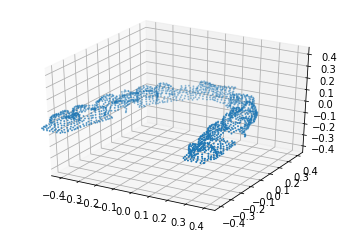

In [ ]:
plot(list_point_clouds[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


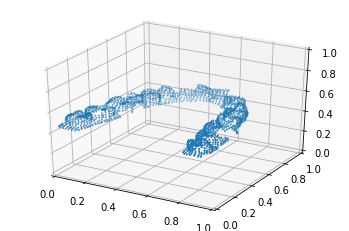

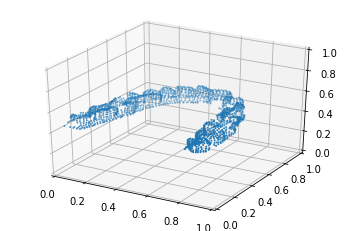

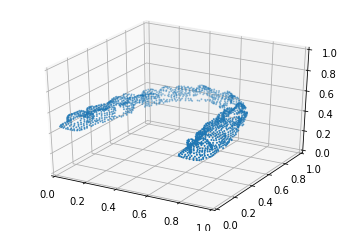

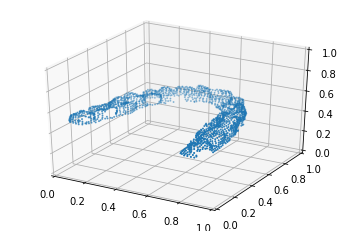

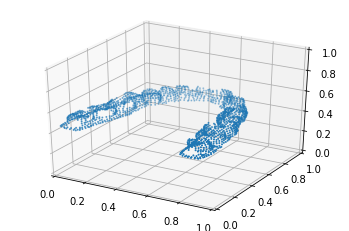

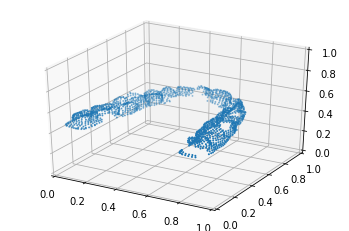

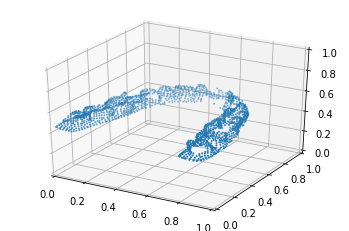

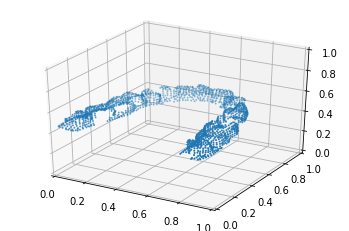

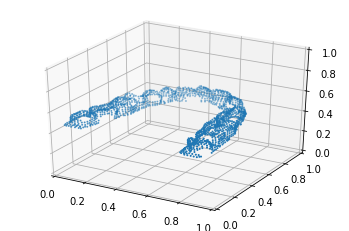

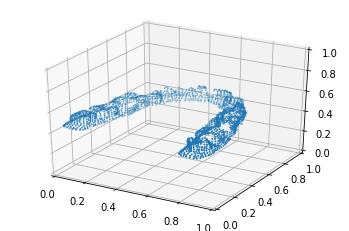

In [ ]:
plotList(10,list_point_clouds)

In [ ]:
X_test=list_point_clouds[0:15]
print(len(X_test))
X_train=list_point_clouds[0:15]
print(X_train.shape)

15
(15, 1741, 3)


In [ ]:
class PointcloudDatasetAE(Dataset):
    def __init__(self, root, list_point_clouds):
        self.root = root
        self.list_files = list_point_clouds
        
    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        points = PyntCloud.from_file(self.list_files[index])
        points.points=points.points[0:2048]
        cx=points.centroid[0]
        cy=points.centroid[1]
        cz=points.centroid[2]
        points = np.array(points.points)
        points=points[:,[0,1,2]]
        points=MoveScale3D(points,-cx,-cy,-cz,1)
        points=points/(2*np.max(points))
        points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        points = points_normalized.astype(np.float)
        points = torch.from_numpy(points)
        
        return points

class PointcloudDatasetNoisy(Dataset):
    def __init__(self,root,list_point_clouds):
        self.root = root
        self.list_files = list_point_clouds
        
    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        points = self.list_files[index]
        points=points[:,[0,1,2]]
        points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        points = points_normalized.astype(np.float)
        points = torch.from_numpy(points)
        
        return points

In [ ]:
train_dataset = PointcloudDatasetNoisy(DATA_DIR, X_train)
train_dataloader = DataLoader(train_dataset, num_workers=0, shuffle=True, batch_size=batch_size)
train_loader_iterator = iter(train_dataloader)

test_dataset = PointcloudDatasetNoisy(DATA_DIR, X_test)
test_dataloader = DataLoader(test_dataset, num_workers=0, shuffle=True, batch_size=1)
test_loader_iterator = iter(test_dataloader)

for i,data in enumerate(train_dataloader):
  print(i)
  if i==0:
    x= data.float().to(device)
    print(x.shape)
  if i==1:
    y = data.float().to(device)
    loss_chamf,_=chamfer_distance(x,y)
    print(loss_chamf)
    break

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


torch.Size([1, 1741, 3])
1
tensor(0.0003, device='cuda:0')


## Models

In [ ]:
shrink

15

In [ ]:
#Generator and Discriminator

num_gen=7760
size_fake=4000
name='New-Z252-0.8z32-42-0.0005-32-[ 64  64 256 256]-2048'
weights_gen = '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanGAN/'+name+'/models/'+str(num_gen)+'_gen_.pt'
weight_disc = '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanGAN/'+name+'/models/'+str(num_gen)+'_disc_.pt'

#ddpg_num=best_time
ddpg_num=int(max_steps-1)

#MODEL_DIR1=MODEL_DIR


MODEL_DIR1='/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanRLAgent/'+'Fake-'+str(0)+'-'+str(max_action)+'-2048/models/'
weight_ddpg = MODEL_DIR1+'Mx:'+str(ddpg_num)+'_ddpg_.pt'

In [ ]:
weight_ddpg

'/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanRLAgent/Fake-0-10-2048/models/Mx:19999_ddpg_.pt'

In [ ]:
torch.cuda.empty_cache()

In [ ]:
autoencoder = AutoEncoder(num_points).to(device)
ext='Orginal+Mirrored-254-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-49-0.8-0.0005-2048-30'
typeFile='Best_Val'
filename='/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/'+ext+'/models/'+typeFile+'_ae_.pth.tar'
autoencoder= load_checkpoint(autoencoder,filename=filename)

=> loading checkpoint '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/Orginal+Mirrored-254-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-49-0.8-0.0005-2048-30/models/Best_Val_ae_.pth.tar'
=> loaded checkpoint '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/Orginal+Mirrored-254-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-49-0.8-0.0005-2048-30/models/Best_Val_ae_.pth.tar' (epoch 4820)


In [ ]:
autoencoder0= AutoEncoder(num_points).to(device)
ext='Orginal+Mirrored-30-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-10-0.8-0.0005-2048-30'
typeFile='Best_Val'
filename='/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/'+ext+'/models/'+typeFile+'_ae_.pth.tar'
autoencoder0= load_checkpoint(autoencoder0,filename=filename)

=> loading checkpoint '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/Orginal+Mirrored-30-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-10-0.8-0.0005-2048-30/models/Best_Val_ae_.pth.tar'
=> loaded checkpoint '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/Orginal+Mirrored-30-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-10-0.8-0.0005-2048-30/models/Best_Val_ae_.pth.tar' (epoch 4290)


In [ ]:
autoencoder1 = AutoEncoder(num_points).to(device)
ext='Orginal+Mirrored-205-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-49-0.8-0.0005-2048-30'
typeFile='Best_Val'
filename='/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/'+ext+'/models/'+typeFile+'_ae_.pth.tar'
autoencoder1= load_checkpoint(autoencoder1,filename=filename)

=> loading checkpoint '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/Orginal+Mirrored-205-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-49-0.8-0.0005-2048-30/models/Best_Val_ae_.pth.tar'
=> loaded checkpoint '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/Orginal+Mirrored-205-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-49-0.8-0.0005-2048-30/models/Best_Val_ae_.pth.tar' (epoch 3187)


In [ ]:

generator = GenSAGAN(z_dim=z_dim).to(device)
generator.load_state_dict(torch.load(weights_gen))

discriminator = DiscSAGAN().to(device)
discriminator.load_state_dict(torch.load(weight_disc))
ddpg = DDPG(max_action).to(device)
ddpg.load_state_dict(torch.load(weight_ddpg))

autoencoder.eval()
generator.eval()
discriminator.eval()
autoencoder1.eval()
autoencoder0.eval()

DATA_DIR = '/content/gdrive/MyDrive/JMSE2022/MoldScan/2048Samples/2021-08-26 04:07:29.716666/'
list_point_clouds = np.load('PC_Arrays/Validation_Dataset/list_point_noisy-3-'+str(org_size)+'-'+str(shrink)+'.npy')
#list_point_clouds = list_point_clouds[:5000]

In [ ]:
list_point_clouds.shape

(15, 1741, 3)

In [ ]:
samples=120

In [ ]:
ROOT_DIR = './MoldScan_Final_results-(Whole)/'
now =   str(datetime.datetime.now())

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)

if not os.path.exists(ROOT_DIR + str(shrink)):
    os.makedirs(ROOT_DIR + str(shrink))

OUTPUTS_DIR = ROOT_DIR  + str(shrink) + '/outputs/'
if not os.path.exists(OUTPUTS_DIR):
    os.makedirs(OUTPUTS_DIR)
txt_DIR = ROOT_DIR  + str(shrink) + '/txt/'
if not os.path.exists(txt_DIR):
    os.makedirs(txt_DIR)

ply_DIR = ROOT_DIR  + str(shrink) + '/ply/'
if not os.path.exists(ply_DIR):
    os.makedirs(ply_DIR)

train_dataset = PointcloudDatasetNoisy(DATA_DIR, X_train)
train_dataloader = DataLoader(train_dataset, num_workers=0, shuffle=True, batch_size=batch_size)

test_dataset = PointcloudDatasetNoisy(DATA_DIR, X_test)
test_dataloader = DataLoader(test_dataset, num_workers=0, shuffle=True, batch_size=1)

In [ ]:
OUTPUTS_DIR

'./MoldScan_Final_results-(Whole)/15/outputs/'

## Dir

In [ ]:
ROOT_DIR = './MoldScanRLAgent/'+'Fake-'+str(shrink)+'-'+str(max_action)+'-'+str(num_points)+'-'+str(Lambda)+'-'+str(Lambda)+'-NoFilters'

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)

if not os.path.exists(ROOT_DIR ):
    os.makedirs(ROOT_DIR)

LOG_DIR = ROOT_DIR + '/logs/'
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

OUTPUTS_DIR = ROOT_DIR   + '/outputs/'
if not os.path.exists(OUTPUTS_DIR):
    os.makedirs(OUTPUTS_DIR)

MODEL_DIR = ROOT_DIR + '/models/'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

summary_writer = SummaryWriter(LOG_DIR)

In [ ]:
start_time = 1e3


In [ ]:
x=torch.tensor([2048])
y=torch.tensor([newdim])
x=x.to(device)
y=y.to(device)

In [ ]:
print(y)

tensor([1741], device='cuda:0')


In [ ]:
OUTPUTS_DIR

'./MoldScanRLAgent/Fake-15-10-2048-10-10-NoFilters/outputs/'

## Additional Data

In [ ]:
ROOT_DIR = './MoldScanRLGAN-(Whole)/'
now =   str(datetime.datetime.now())

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)

if not os.path.exists(ROOT_DIR + str(shrink)):
    os.makedirs(ROOT_DIR + str(shrink))

OUTPUTS_DIR = ROOT_DIR  + str(shrink) + '/outputs/'
if not os.path.exists(OUTPUTS_DIR):
    os.makedirs(OUTPUTS_DIR)
txt_DIR = ROOT_DIR  + str(shrink) + '/txt/'
if not os.path.exists(txt_DIR):
    os.makedirs(txt_DIR)

ply_DIR = ROOT_DIR  + str(shrink) + '/ply/'
if not os.path.exists(ply_DIR):
    os.makedirs(ply_DIR)

In [ ]:
Original = PointcloudDatasetNoisy(DATA_DIR, X_train)

In [ ]:
X_train.shape

(15, 1741, 3)

In [ ]:
a = np.load('./PC_Arrays/GAN-1-(1240, 2048, 3).npy',allow_pickle=True)
pointsAE=a[1] # Validation data

In [ ]:
pointsAE.shape 

(15, 2048, 3)

In [ ]:
cropped = np.load('PC_Arrays/Validation_Dataset/list_point_noisy-3-'+str(org_size)+'-'+str(shrink)+'.npy') # Incomplete datasets
#firstDist= np.load('./FirstDist.npy',allow_pickle=True)
original = pointsAE

In [ ]:
cropped.shape

(15, 1741, 3)

In [ ]:
original.shape

(15, 2048, 3)

In [ ]:
X_test.shape

(15, 1741, 3)

In [ ]:
org = PointcloudDatasetNoisy(DATA_DIR, original)
org_dataloader = DataLoader(org, num_workers=0, shuffle=False, batch_size=batch_size)
crop = PointcloudDatasetNoisy(DATA_DIR, cropped[0:15])
crop_dataloader = DataLoader(crop, num_workers=0, shuffle=False, batch_size=batch_size)

In [ ]:
for i,data in enumerate(org_dataloader):
  print(i)
  if i==0:
    x= data.float().to(device)
    print(x.shape)
  if i==1:
    y = data.float().to(device)
    loss_chamf,_=chamfer_distance(x,y)
    print(loss_chamf)
    break

0
torch.Size([1, 2048, 3])
1
tensor(0.0003, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
for i,data in enumerate(crop_dataloader):
  print(i)
  if i==0:
    x1= data.float().to(device)
    print(x.shape)
  if i==1:
    y1 = data.float().to(device)
    loss_chamf,_=chamfer_distance(x1,y1)
    print(loss_chamf)
    break

0
torch.Size([1, 2048, 3])
1
tensor(0.0004, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
loss_chamf,_=chamfer_distance(y1,y)
print(loss_chamf)

tensor(9.6036e-05, device='cuda:0')


# Results

In [ ]:
OUTPUTS_DIR

'./MoldScanRLGAN-(Whole)/15/outputs/'

In [ ]:
samples=15

In [ ]:
GAN_chamf=[]
crop_chamf=[]
AE_chamf=[]
AE0_chamf=[]
AE1_chamf=[]
hybrid_chamf=[]
diff1=[]
diff=[]
for i, data in enumerate(crop_dataloader):
    data = data.float().to(device)
    state_t = autoencoder.encode(data)
    state_t1 = autoencoder1.encode(data)
    #org_gfv = autoencoder.encode(data)

    optimal_action = ddpg.get_optimal_action(state_t).detach()
    new_state, _ = generator(optimal_action)
    with torch.no_grad():
      reward_GAN, _ = discriminator(new_state) 

      #RL-GAN
    out_data = autoencoder.decode(new_state)
    #out_data= autoencoder1.encode(out_data)
    #out_data= autoencoder.decode(out_data)
    output_GAN=out_data

    out_data=out_data.permute([0,2,1])


    output = out_data[0,:,:]
    output = output.permute([1,0]).detach().cpu().numpy()

    data=data.permute([0,2,1])
    inputt = data[0,:,:]
    inputt = inputt.permute([1,0]).detach().cpu().numpy()


    # AE
    output_AE = autoencoder.decode(state_t)
    output_AE1 = autoencoder1.decode(state_t1)
    output_AE0 = autoencoder0.decode(state_t1)
    data1= org_dataloader.dataset[i]
    data1=data1.unsqueeze(0)
    data1=data1.float().to(device)

    #Select Best reconstruction
    data = data.permute([0,2,1])
    reward_AE,_=chamfer_distance(data,output_AE)
    reward_GAN,_=chamfer_distance(data,output_GAN)
    #with torch.no_grad():
    #  reward_AE, _ = discriminator(autoencoder_hyb.encode(output_AE))
    if reward_GAN<reward_AE:
      hybrid_data=output_GAN
    else:
      hybrid_data=output_AE

    if i==0:
      reff1=output_GAN
      reff=data1

    #Compare


    chamf_comp=chamfer_distance(data1,output_GAN)
    chamf_crop=chamfer_distance(data1,data)
    AE_chf=chamfer_distance(data1,output_AE)
    AE1_chf=chamfer_distance(data1,output_AE1)
    AE0_chf=chamfer_distance(data1,output_AE0)
    hybrid_chf=chamfer_distance(data1,hybrid_data)
    reff_chf=chamfer_distance(output_GAN,reff)
    reff1_chf=chamfer_distance(output_GAN,reff1)
    #hybrid_GAN.append(np.min(chamf_comp,AE_chf))
    GAN_chamf.append(chamf_comp)
    AE_chamf.append(AE_chf)
    AE1_chamf.append(AE1_chf)
    AE0_chamf.append(AE0_chf)
    hybrid_chamf.append(hybrid_chf)
    crop_chamf.append(chamf_crop)
    diff.append(reff_chf)
    diff1.append(reff1_chf)


    plt.close('all')

    #if i >= samples-1:
     #   break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
hybrid_chamf

[(tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>), None),
 (tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>), None)]

In [ ]:
mirror_chamf=[]
GAN_chamf2=[]
AE_chamf2=[]
AE1_chamf2=[]
AE0_chamf2=[]
crop_chamf2=[]
hybrid_chamf2=[]
diff_chamf=[]
diff1_chamf=[]


for i in range(len(GAN_chamf)):
  if (i%1 ==0):
    gan=np.array(GAN_chamf[i][0].cpu().detach().numpy())
    GAN_chamf2.append(GAN_chamf[i][0].cpu().detach().numpy())
    crop_chamf2.append(crop_chamf[i][0].cpu().detach().numpy())
    AE_chamf2.append(AE_chamf[i][0].cpu().detach().numpy())
    ae2=np.array(AE_chamf[i][0].cpu().detach().numpy())
    AE1_chamf2.append(AE1_chamf[i][0].cpu().detach().numpy())
    AE0_chamf2.append(AE0_chamf[i][0].cpu().detach().numpy())
    hybrid_chamf2.append(hybrid_chamf[i][0].cpu().detach().numpy())
    diff_chamf.append(diff[i][0].cpu().detach().numpy())
    diff1_chamf.append(diff1[i][0].cpu().detach().numpy())
  else:
    mirror_chamf.append(GAN_chamf[i][0].cpu().detach().numpy())

In [ ]:
diff_chamf

[array(0.00015918, dtype=float32),
 array(0.00015941, dtype=float32),
 array(0.00015961, dtype=float32),
 array(0.00015935, dtype=float32),
 array(0.00015925, dtype=float32),
 array(0.00015968, dtype=float32),
 array(0.00015952, dtype=float32),
 array(0.00015915, dtype=float32),
 array(0.0001596, dtype=float32),
 array(0.00015938, dtype=float32),
 array(0.00015916, dtype=float32),
 array(0.00015936, dtype=float32),
 array(0.00015948, dtype=float32),
 array(0.00015997, dtype=float32),
 array(0.00015942, dtype=float32)]

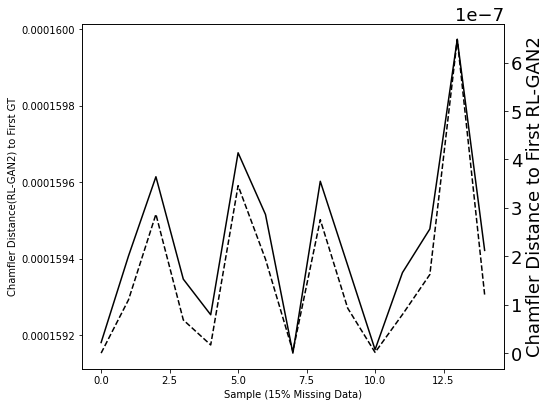

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))
plt.rcParams['font.size'] = '18'
color = 'k'
ax1.plot(diff_chamf,'-',color='k')
ax1.set_xlabel('Sample ('+str(shrink)+'% Missing Data)')
ax1.set_ylabel('Chamfler Distance(RL-GAN2) to First GT',color='k')
ax1.tick_params(axis='y', color='k')
#ax1.set_ylim(0,0.06)
ax2 = ax1.twinx()  
ax2.set_ylabel('Chamfler Distance to First RL-GAN2', color='k')  
#ax2.plot(per,AE1_cha,color='black',label='AE1')
#ax2.plot(per,AE_cha,color='red',label='AE2')
#ax2.plot(per,Crop_cha,color='blue',label='Incoplete PC')
ax2.plot(diff1_chamf,'--',color='k')
ax2.tick_params(axis='y', labelcolor='k')
fig.tight_layout()
  
figname=OUTPUTS_DIR+'Compare.png'
fig.savefig(figname)

In [ ]:
hybrid_chamf2

[array(0.00016136, dtype=float32),
 array(0.00022439, dtype=float32),
 array(0.00020032, dtype=float32),
 array(0.00028477, dtype=float32),
 array(0.00015871, dtype=float32),
 array(0.00035483, dtype=float32),
 array(0.00023181, dtype=float32),
 array(0.00015743, dtype=float32),
 array(0.00030591, dtype=float32),
 array(0.00024574, dtype=float32),
 array(0.00015593, dtype=float32),
 array(0.00014905, dtype=float32),
 array(0.00021602, dtype=float32),
 array(0.00051009, dtype=float32),
 array(0.00019277, dtype=float32)]

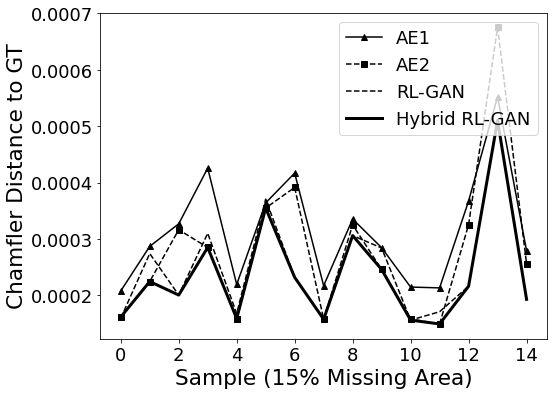

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))
plt.rcParams['font.size'] = '18'
color = 'tab:red'
color='black'
wdt=1.5
#ax1.plot(AE0_chamf2,'ko-',label='AE0',linewidth=1)
ax1.plot(AE1_chamf2,'k^-',label='AE1',linewidth=wdt)
ax1.plot(AE_chamf2,'ks--',label='AE2',linewidth=wdt)
color = 'tab:blue'
ax1.plot(GAN_chamf2,'k--',label='RL-GAN',linewidth=wdt)
color='black'
ax1.plot(hybrid_chamf2,'k-',label='Hybrid RL-GAN',linewidth=2*wdt)
ax1.set_xlabel('Sample ('+str(shrink)+'% Missing Area)',fontsize='large')
ax1.set_ylabel('Chamfler Distance to GT',color='black',fontsize='large')
ax1.tick_params(axis='y', color=color)
ax1.legend(loc = 'upper right', ncol=1)
#ax1.set_ylim(0.00015,0.0016)
'''ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Chamfler Distance(RL-GAN)', color=color)  
ax2.plot(GAN_chamf2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
#ax2.set_ylim(0,0.002)'''
  
figname=OUTPUTS_DIR+str(shrink)+'-Original.png'
fig.savefig(figname)

In [ ]:
OUTPUTS_DIR

'./MoldScanRLGAN-(Whole)/15/outputs/'

In [ ]:
np.mean(crop_chamf2)

0.00010410214

In [ ]:
np.mean(GAN_chamf2)

0.00024708343

In [ ]:
np.mean(AE_chamf2)

0.00027884392

In [ ]:
np.mean(AE1_chamf2)

0.00031393804

In [ ]:
np.mean(AE0_chamf2)

0.0007823092

In [ ]:
np.mean(hybrid_chamf2)

0.00023660807

In [ ]:
len(org_dataloader)

15

In [ ]:
sample=0
PC=org_dataloader.dataset[sample]
PC=PC.unsqueeze(0)
PC=PC.float().to(device)
diff_to_PC=[]

for i in range(len(org_dataloader)):
    data1= org_dataloader.dataset[i]
    data1=data1.unsqueeze(0)
    data1=data1.float().to(device)

    chamf_comp=chamfer_distance(data1,PC)
    #hybrid_GAN.append(np.min(chamf_comp,AE_chf))
    diff_to_PC.append(chamf_comp[0].cpu().detach().numpy())

    #if i >= samples-1:
     #   break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
diff_to_PC

[array(0., dtype=float32),
 array(0.00026861, dtype=float32),
 array(0.00019775, dtype=float32),
 array(0.00030256, dtype=float32),
 array(0.00011132, dtype=float32),
 array(0.00043052, dtype=float32),
 array(0.0001891, dtype=float32),
 array(0.00013773, dtype=float32),
 array(0.00031733, dtype=float32),
 array(0.00031384, dtype=float32),
 array(0.00016134, dtype=float32),
 array(0.00017871, dtype=float32),
 array(0.00016769, dtype=float32),
 array(0.00057323, dtype=float32),
 array(0.00020421, dtype=float32)]

Text(0.5, 0, 'Raw Pcs')

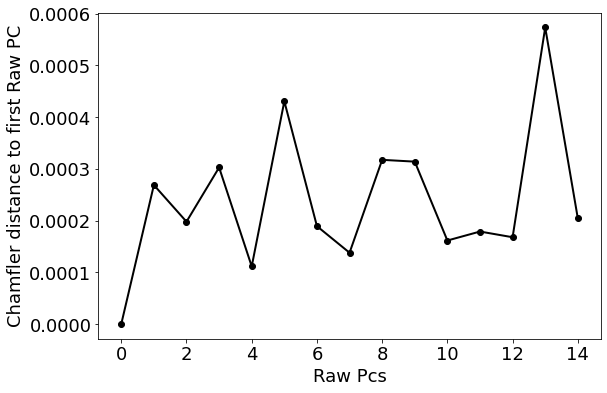

In [ ]:
fig, ax1 = plt.subplots(figsize=(9,6))
plt.rcParams['font.size'] = '18'
wdt=2
#ax1.plot(per,Crop_cha,'k--',label='Incoplete PC',linewidth=wdt)
#ax1.plot(per,AE0_cha,'ko-',label='AE0',linewidth=wdt)
ax1.plot(diff_to_PC,'ko-',label='Diff to sample 0',linewidth=wdt)
ax1.set_ylabel('Chamfler distance to first Raw PC',color='k')
ax1.set_xlabel('Raw Pcs',color='k')


# PNG and txt

In [ ]:
samples=15

In [ ]:
for i, data in enumerate(crop_dataloader):
    data = data.float().to(device)
    state_t = autoencoder.encode(data)
    state_t1 = autoencoder1.encode(data)

    optimal_action = ddpg.get_optimal_action(state_t).detach()
    new_state, _ = generator(optimal_action)
    
    out_data = autoencoder.decode(new_state)
    out_data=out_data.permute([0,2,1])


    output = out_data[0,:,:]
    output = output.permute([1,0]).detach().cpu().numpy()

    data=data.permute([0,2,1])
    inputt = data[0,:,:]
    inputt = inputt.permute([1,0]).detach().cpu().numpy()


    fig = plt.figure()
    ax_x = fig.add_subplot(111, projection='3d')
    x_ = inputt
    ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
    ax_x.set_xlim([0,1])
    ax_x.set_ylim([0,1])
    ax_x.set_zlim([0,1])
    df = pd.DataFrame(x_, columns=['X axis', 'Y axis', 'Z axis'])
    namefile=str(i)+':input.txt'
    df.to_csv(r'.'+txt_DIR[1:]+namefile, header=None, index=None, sep=' ', mode='a')
    fig.savefig(OUTPUTS_DIR+'/{}_{}.png'.format(i, 'in'))

    fig = plt.figure()
    ax_x = fig.add_subplot(111, projection='3d')
    x_ = output
    ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
    ax_x.set_xlim([0,1])
    ax_x.set_ylim([0,1])
    ax_x.set_zlim([0,1])
    df = pd.DataFrame(x_, columns=['X axis', 'Y axis', 'Z axis'])
    namefile=str(i)+':RL-GAN.txt'
    df.to_csv(r'.'+txt_DIR[1:]+namefile, header=None, index=None, sep=' ', mode='a')
    fig.savefig(OUTPUTS_DIR+'/{}_{}.png'.format(i, 'RL-GAN'))

    output = autoencoder.decode(state_t)
    output= output.permute([0,2,1])
    output = output[0,:,:]
    output = output.permute([1,0]).detach().cpu().numpy()

    fig = plt.figure()
    ax_x = fig.add_subplot(111, projection='3d')
    x_ = output
    ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
    ax_x.set_xlim([0,1])
    ax_x.set_ylim([0,1])
    ax_x.set_zlim([0,1])
    df = pd.DataFrame(x_, columns=['X axis', 'Y axis', 'Z axis'])
    namefile=str(i)+':AE2.txt'
    df.to_csv(r'.'+txt_DIR[1:]+namefile, header=None, index=None, sep=' ', mode='a')
    fig.savefig(OUTPUTS_DIR+'/{}_{}.png'.format(i, 'AE2'))

    output1 = autoencoder1.decode(state_t1)
    output1= output1.permute([0,2,1])
    output1 = output1[0,:,:]
    output1 = output1.permute([1,0]).detach().cpu().numpy()

    fig = plt.figure()
    ax_x = fig.add_subplot(111, projection='3d')
    x_ = output1
    ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
    ax_x.set_xlim([0,1])
    ax_x.set_ylim([0,1])
    ax_x.set_zlim([0,1])
    df = pd.DataFrame(x_, columns=['X axis', 'Y axis', 'Z axis'])
    namefile=str(i)+':AE1.txt'
    df.to_csv(r'.'+txt_DIR[1:]+namefile, header=None, index=None, sep=' ', mode='a')
    fig.savefig(OUTPUTS_DIR+'/{}_{}.png'.format(i, 'AE1'))

    plt.close('all')

    if i > samples:
        break
for i, data in enumerate(org_dataloader):
    data = data.float().to(device) 

    data=data.permute([0,2,1])
    inputt = data[0,:,:]
    inputt = inputt.permute([1,0]).detach().cpu().numpy()

    fig = plt.figure()
    ax_x = fig.add_subplot(111, projection='3d')
    x_ = inputt
    ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2],s=mark, marker='o')
    ax_x.set_xlim([0,1])
    ax_x.set_ylim([0,1])
    ax_x.set_zlim([0,1])
    df = pd.DataFrame(x_, columns=['X axis', 'Y axis', 'Z axis'])
    namefile=str(i)+':Org.txt'
    df.to_csv(r'.'+txt_DIR[1:]+namefile, header=None, index=None, sep=' ', mode='a')
    fig.savefig(OUTPUTS_DIR+'/{}_{}.png'.format(i, 'Org'))

    plt.close('all')

    if i > samples:
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
OUTPUTS_DIR

'./MoldScanRLGAN-(Whole)/5/outputs/'

# Save Ply

In [ ]:
list_point_clouds=listDir(txt_DIR)
list_point_clouds=np.sort(list_point_clouds)
for i in range(len(list_point_clouds)):
  nameply='None.ply'
  cloud = PyntCloud.from_file(list_point_clouds[i],sep=" ",names=["x","y","z"])
  if (list_point_clouds[i].find('AE2')!=-1):
    nameply=str(np.ceil((i+1)/5)-1)+':AE2.ply'
  if (list_point_clouds[i].find('AE1')!=-1):
    nameply=str(np.ceil((i+1)/5)-1)+':AE1.ply'
  if (list_point_clouds[i].find('RL-GAN')!=-1):
    nameply=str(np.ceil((i+1)/5)-1)+':RL-GAN.ply'
  if (list_point_clouds[i].find('input')!=-1):
    nameply=str(np.ceil((i+1)/5)-1)+':input.ply'
  if (list_point_clouds[i].find('Org')!=-1):
    nameply=str(np.ceil((i+1)/5)-1)+':Org.ply'
  cloud.to_file(ply_DIR+nameply)
  

# Plots

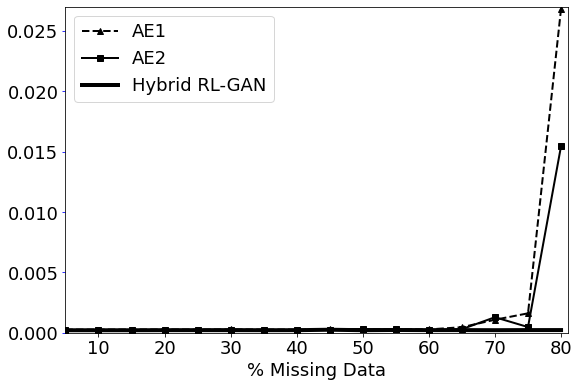

In [ ]:
color='b'
end=12
per=np.array(([5,
10,
15,
20,
25,
30,
35,
40,
45,
50,
55,
60,
65,
70,
75,
80

]))
AE0_cha=np.array(([
0.00071456964,
0.00071456964,
0.00071456964,
0.00071456964,
0.00071456964,
0.00071456964,
0.00071456964,
0.00071456964,
0.00071456964,
0.00071456964,
0.0071456964,
0.00071456964,
0.00071456964,
0.013214069,
0.009847698,
0.017441692

]))
AE1_cha=np.array(([
0.0002623991,
0.00026306417,
0.00027104933,
0.00027089758,
0.000268007,
0.00027739356,
0.0002679693,
0.00026867632,
0.00028160083,
0.00031554574,
0.0003052334,
0.00028057722,
0.0004631394,
0.0010814667,
0.0016121067,
0.026817556
]))
AE_cha=np.array(([0.00021344844,
0.0002125312,
0.00022778829,
0.00023639448,
0.00023317915,
0.00026680384,
0.00022195606,
0.00022365314,
0.0002692146,
0.00031466398,
0.00027985277,
0.00023669326,
0.00030203766,
0.0012896116,
0.00047540703,
0.015454176
]))

GAN_cha=np.array(([0.00022530611,
0.00022527039,
0.00022534061,
0.00022477048,
0.00022495406,
0.00022478997,
0.0002253149,
0.00022516129,
0.00022477224,
0.00022467248,
0.0002246091,
0.00022525503,
0.00022419533,
0.00022480842,
0.00022419126,
0.00022297776

]))
Crop_cha=np.array(([
3.27926140000e-5,
6.73138060000e-5,
0.000110078734,
0.00014946259,
0.00019661216,
0.00025063177,
0.00031016808,
0.0004105123,
0.00046365595,
0.00058249536,
0.0006511163,
0.00084223144,
0.0010027959,
0.0012502312,
0.0017385889,
0.002264757

]))
Hybrid_cha=np.array(([0.00021103516,
0.0002110548,
0.00021110802,
0.000216576,
0.00021825531,
0.00021683761,
0.00021429699,
0.00021614178,
0.00025375132,
0.00021467675,
0.00023140358,
0.00021993255,
0.00022251067,
0.00021569474,
0.0002241829,
0.00022615129

]))

fig, ax1 = plt.subplots(figsize=(9,6))
plt.rcParams['font.size'] = '18'
wdt=2
#ax1.plot(per,Crop_cha,'k--',label='Incoplete PC',linewidth=wdt)
#ax1.plot(per,AE0_cha,'ko-',label='AE0',linewidth=wdt)
ax1.plot(per,AE1_cha,'k^--',label='AE1',linewidth=wdt)
ax1.plot(per,AE_cha,'ks-',label='AE2',linewidth=wdt)
#ax1.plot(per,GAN_cha,'k--',label='RL-GAN',linewidth=wdt)
ax1.plot(per,Hybrid_cha,'k-',label='Hybrid RL-GAN',linewidth=2*wdt)
ax1.set_xlabel('% Missing Data',color='black')
#ax1.set_ylabel('Chamfler Distance to GT',color='black')
ax1.tick_params(axis='y', color=color)
ax1.legend(loc = 'upper left', ncol=1)
ax1.set_ylim(0.0,0.027)
ax1.set_xlim(5,81)

'''ax2 = ax1.twinx()  
#ax2.set_ylabel('AE0 Chamfler Distance to GT', color='black')  
ax2.plot(per,Crop_cha,'k:',label='Incoplete PC',linewidth=wdt)
#ax2.plot(per,AE1_cha,color='black',label='AE1')
#ax2.plot(per,AE_cha,color='red',label='AE2')
#ax2.plot(per,Crop_cha,color='blue',label='Incoplete PC')
#ax2.plot(per,GAN_cha,color=color,label='RL-GAN2')
ax2.plot(per,AE0_cha,'k^-',label='AE0',linewidth=wdt)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(-0.0010,0.012)
fig.tight_layout()
ax2.legend(loc = 'center left', ncol=1)'''



figname=ROOT_DIR+str(end*5)+'FinalChamf.png'
fig.savefig(figname)

In [ ]:
OUTPUTS_DIR

'./MoldScanRLGAN/35/outputs/'

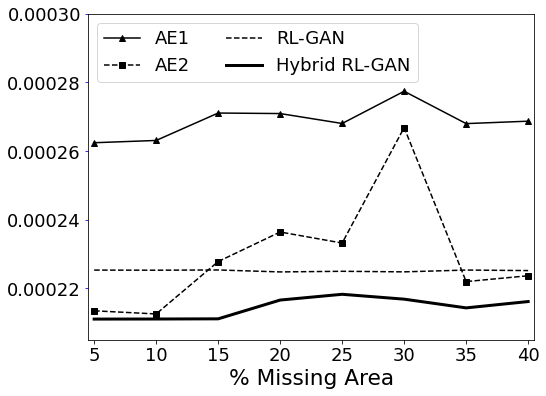

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))
plt.rcParams['font.size'] = '18'
end=8
wdt=1.5
#ax1.plot(per,Crop_cha,color='blue',label='Incoplete PC')
#ax1.plot(per[0:end],AE0_cha[0:end],color='black',label='AE2')
ax1.plot(per[0:end],AE1_cha[0:end],'k^-',label='AE1',linewidth=wdt)
ax1.plot(per[0:end],AE_cha[0:end],'ks--',label='AE2',linewidth=wdt)
ax1.plot(per[0:end],GAN_cha[0:end],'k--',label='RL-GAN',linewidth=wdt)
ax1.plot(per[0:end],Hybrid_cha[0:end],'k-',label='Hybrid RL-GAN',linewidth=2*wdt)
ax1.set_xlabel('% Missing Area',color='black',fontsize='large')
#ax1.set_ylabel('Chamfler Distance to GT',color='black')
ax1.tick_params(axis='y', color=color)
ax1.legend(loc = 'upper left',ncol=2)
ax1.set_ylim(0.000205,0.00030)
ax1.set_xlim(4.5,40.5)
'''ax2 = ax1.twinx()  
ax2.set_ylabel('Chamfler Distance to GT (Incoplete PC) ', color='black')  
#line1.set_dashes([2, 2, 10, 2]) 
#ax2.plot(per,AE_cha,color='red',label='AE1')
#ax2.plot(per,AE_cha,color='red',label='AE2')
#ax2.plot(per,Crop_cha,color='blue',label='Incoplete PC')
ax2.plot(per,GAN_cha,color='black',label='RL-GAN2')
#ax2.plot(per,Hybrid_cha,color='green',label='Hybrid')
ax2.tick_params(axis='y', labelcolor='black')
fig.tight_layout()
#ax2.legend(loc = 'lower right')'''


figname=ROOT_DIR+str(end*5)+'FinalChamf-2.png'
fig.savefig(figname)

In [ ]:
OUTPUTS_DIR

'./MoldScanRLGAN/80/outputs/'

In [ ]:
F1=np.load('PC_Arrays/F1-Shapes(205, 2048, 3).npy',allow_pickle=True)
F2=np.load('PC_Arrays/F2-Shapes(205, 2048, 3).npy',allow_pickle=True)

In [ ]:
F1

array([532, 628, 735, 775, 825, 829, 876, 911, 921, 924])

In [ ]:
F2

array([32, 30, 33, 31, 27, 26, 29, 29, 28, 20])

In [ ]:
Rem=F2
F2=F1-F2
F1=1000-F1
Org=1000*np.ones((10))

In [ ]:
Org=1000*np.ones((10))

In [ ]:
F1

array([468, 372, 265, 225, 175, 171, 124,  89,  79,  76])

In [ ]:
F2

array([500, 598, 702, 744, 798, 803, 847, 882, 893, 904])

In [ ]:
Org

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000.])

# Filtered Data

In [ ]:
All_Fake=np.load('PC_Arrays/All_Fake_PCs.npy',allow_pickle=True)
All_Fake.shape

(285, 2048, 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 285/285 [00:00<00:00, 486.46it/s]


Removed Points: 0 .Remaining Points: 285
Average: 0.00034517876 Std 4.2218584e-05


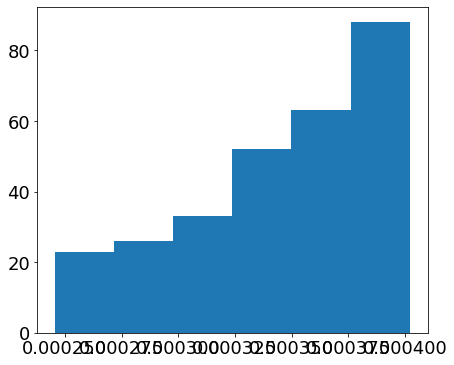

In [ ]:
_=Filter1(All_Fake,18)

In [ ]:
F1=np.load('PC_Arrays/F1-Shapes(205, 2048, 3).npy',allow_pickle=True)
F2=np.load('PC_Arrays/F2-Shapes(205, 2048, 3).npy',allow_pickle=True)

In [ ]:
F1

array([532, 628, 735, 775, 825, 829, 876, 911, 921, 924])

In [ ]:
F2

array([32, 30, 33, 31, 27, 26, 29, 29, 28, 20])

In [ ]:
Rem=F2
F2=F1-F2
F1=1000-F1
Org=1000*np.ones((10))

In [ ]:
ac=0
total=[]
for i in range(len(Rem)):
  ac=Rem[i]+ac
  total.append(ac)

In [ ]:
total

[32, 62, 95, 126, 153, 179, 208, 237, 265, 285]

In [ ]:
elements=[]
for i in range(len(Org)):
  elements.append(i+1)
elements=np.array(elements)

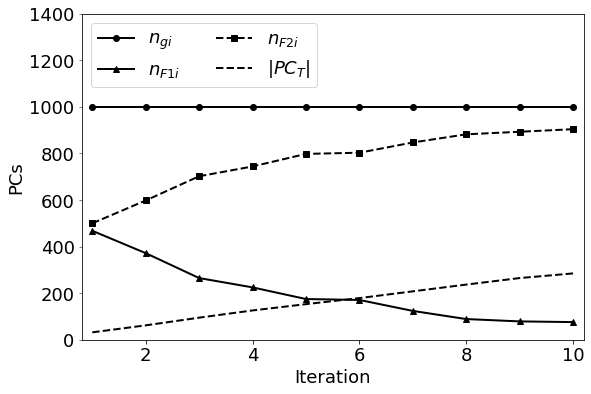

In [ ]:
color = 'tab:blue'
fig, ax1 = plt.subplots(figsize=(9, 6))
plt.rcParams['font.size'] = '18'
wdt=2
ax1.plot(elements,Org,'ko-',label='$n_{gi}$',linewidth=wdt)
ax1.plot(elements,F1,'k^-',label='$n_{F1i}$',linewidth=wdt)
ax1.plot(elements,F2,'ks--',label='$n_{F2i}$',linewidth=wdt)
#ax1.plot(elements,Rem,color='orange',label='$n_{fi}$')
ax1.plot(elements,total,'k--',label='$|PC_T|$',linewidth=wdt)
ax1.set_ylabel('PCs',color='black',fontsize='medium')
ax1.set_xlabel('Iteration',color='black',fontsize='medium')
ax1.tick_params(axis='y', color=color)
ax1.legend(loc = 'upper left',ncol=2,fontsize='medium')

ax1.set_ylim(0,1400)
ax1.set_xlim(0.8,10.2)

'''ax2 = ax1.twinx()  
ax2.set_ylabel('$n_{fi}$', color='black')  
ax2.plot(elements,Rem,color='orange')
ax2.tick_params(axis='y', labelcolor='black')
fig.tight_layout()

ax2.set_ylim(15,40)'''
fig.savefig('it-lGAN.png')


In [ ]:
All_its=np.load('PC_Arrays/All-Its.npy',allow_pickle=True)

In [ ]:
All_its.shape

(49, 2048, 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 49/49 [00:00<00:00, 386.64it/s]


Removed Points: 0 .Remaining Points: 49
Average: 0.00035174348 Std 3.8734146e-05


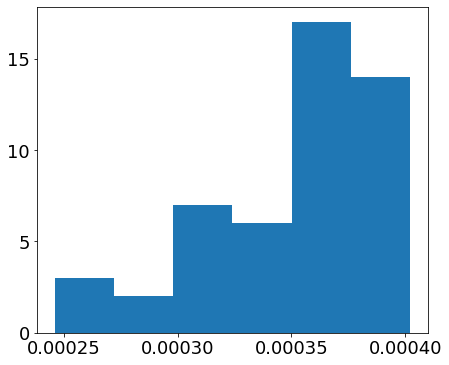

In [ ]:
_=Filter1(All_its,22)

In [ ]:
pointsAE = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)
pointsAE= (pointsAE - (-0.5)) / (0.5 - (-0.5))

In [ ]:
pointsAE2 = np.load('./PC_Arrays/pointsAE-(240, 2048, 3).npy',allow_pickle=True)
pointsAE2= (pointsAE2 - (-0.5)) / (0.5 - (-0.5))

In [ ]:
pointsAE2.shape

(205, 2048, 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 30/30 [00:00<00:00, 429.89it/s]


Removed Points: 1 .Remaining Points: 29
Average: 0.00020035109 Std 8.610786e-05


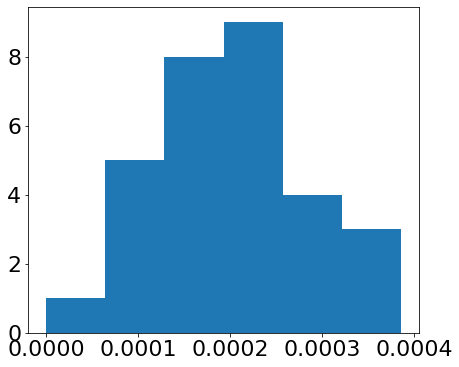

In [ ]:
_=Filter1(pointsAE[0:30],22)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 210/210 [00:00<00:00, 510.04it/s]


Removed Points: 0 .Remaining Points: 210
Average: 0.00023185097 Std 4.8525486e-05


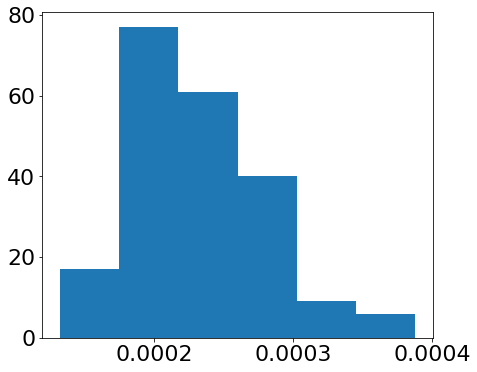

In [ ]:
_=Filter1(pointsAE[30:],22)

In [ ]:
pointsAE2 = np.load('./PC_Arrays/pointsAE-(240, 2048, 3).npy',allow_pickle=True)
pointsAE2= (pointsAE2 - (-0.5)) / (0.5 - (-0.5))
pointsAE2.shape

(205, 2048, 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 175/175 [00:00<00:00, 650.51it/s]


Removed Points: 0 .Remaining Points: 175
Average: 0.00023449413 Std 5.060629e-05


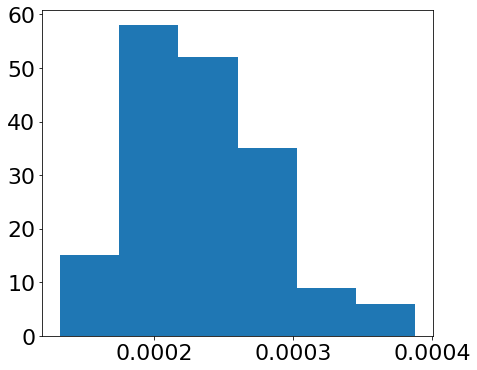

In [ ]:
_=Filter1(pointsAE2[30:],22)

In [ ]:
pointsAE2.shape

(205, 2048, 3)